In [583]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tifffile

from IPython.display import Image
from openpiv import tools, pyprocess, validation

# Local import
from piv.points_df import Points

## Data Loading

We start by selecting the appropriate parameters. Given the exploratory analysis in `data_exploration.ipynb`, the ideal window size in our case is between 8 and 32, balancing granularity with sparsity. The search size we choose ~2x as large. Ideally, this is the window size plus the expected maximum number of pixels a point would move, but choosing anything larger than this will work. The overlap specifies how much the template window (window size) and search window can overlap. Finally, dt gives the timestep in between frames. Since the video was taken at 10FPS, one frame time is 0.1 seconds.

In [584]:
opiv_window_size = 16
opiv_search_size = 20
opiv_overlap = 8
opiv_dt = 0.1

Next, we define the experiment that we will be using. In this case, it will be `220530-E1_Out`.

In [585]:
experiment = '220530-E1_Out'

We now read the image data for this experiment. The result is an $n$-dimensional TIFF file with dimensions for the color channels, spatial x and y dimensions and the temporal dimension (z or t).

In [586]:
# Reading in the image from the associated experiment
image_dir = 'data/tiff'
image_file = [f for f in os.listdir(image_dir) if experiment in f and f.endswith('.tiff')] # type: ignore
if len(image_file) > 1:
    raise ValueError(f'Expected only one image for experiment {experiment}, but found {len(image_file)}')

image = tifffile.TiffFile(f'{image_dir}/{image_file[0]}')
image_data = np.squeeze(image.asarray())

Some data processing to get the color channel data into a numpy array.

In [587]:
# Preparation for visual plotting
channel_red     = image_data[0] # shape -> (115, 512, 512)
channel_green   = image_data[1] # shape -> (115, 512, 512)

# Normalize for visualization 
channel_red_norm    = channel_red / channel_red.max()
channel_green_norm  = channel_green / channel_green.max()

# Create RG(B) stack for each slice
rgb_stack = np.zeros((115, 512, 512, 2), dtype=np.float32)
rgb_stack[..., 0] = channel_red_norm    # Red
rgb_stack[..., 1] = channel_green_norm  # Green

## Obtaining the velocity map with OpenPIV

Next we can infer the velocities between two frames given the settings and the image data using OpenPIV. For this, we select two frame indices and the implementation will try to infer the velocities of the points between the frames. From the `rgb_stack`, we choose a random color channel, in this case the RED channel.

In [588]:
frame_index_a = 4
frame_index_b = 5

frame_a_fl = rgb_stack[frame_index_a][..., 0]
frame_b_fl = rgb_stack[frame_index_b][..., 0]

We wrangle the data to be in an integer format between 0 and 255 (currently, the values are stored as floating point numbers between 0 and 1)

In [589]:
frame_a = (frame_a_fl * 255).astype(np.uint32)
frame_b = (frame_b_fl * 255).astype(np.uint32)

We then utilize the OpenPIV implementation to obtain the velocities.

In [590]:
vel_x, vel_y, signal_to_noise = pyprocess.extended_search_area_piv(
    frame_a,
    frame_b,
    window_size     = opiv_window_size,
    overlap         = opiv_overlap,
    dt              = opiv_dt,
    search_area_size= opiv_search_size,
    sig2noise_method='peak2peak'
)

We can obtain the coordinates of the velocity vectors.

In [591]:
x, y = pyprocess.get_coordinates(
    image_size      = frame_a.shape,
    search_area_size= opiv_search_size,
    overlap         = opiv_overlap
)

We can now extract the vectors that have a magnitude large enough compared to the noise ratio. We can first inspect the signal-to-noise ratios.

In [592]:
#plt.hist(signal_to_noise.flatten())

We will filter with a threshold of 1.

In [593]:
vel_x, vel_y, invalid_mask = validation.sig2noise_val(
    vel_x, 
    vel_y,
    signal_to_noise, 
    threshold=1.0
)

Some transform the velocities to be at the propper positions before plotting.

In [594]:
x, y, vel_x, vel_y = tools.transform_coordinates(x, y, vel_x, vel_y)

Finally, we save the original template frame to a BMP file. This is necessary because OpenPIV doesn't accept TIFF files and requires a file path instead of an image object when overlaying an image.

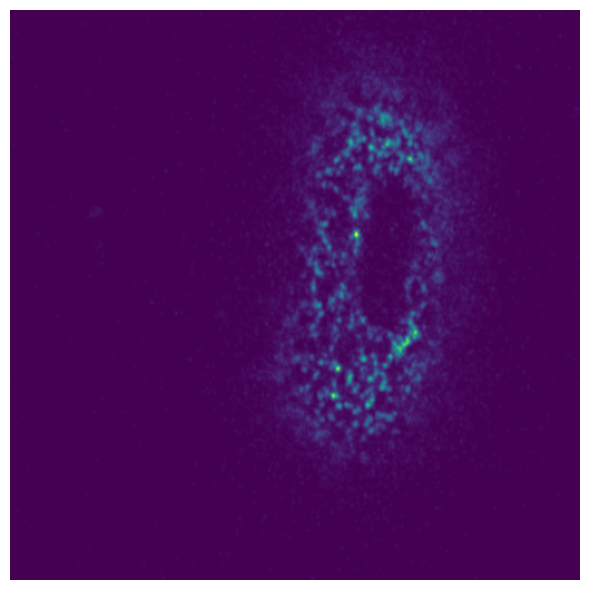

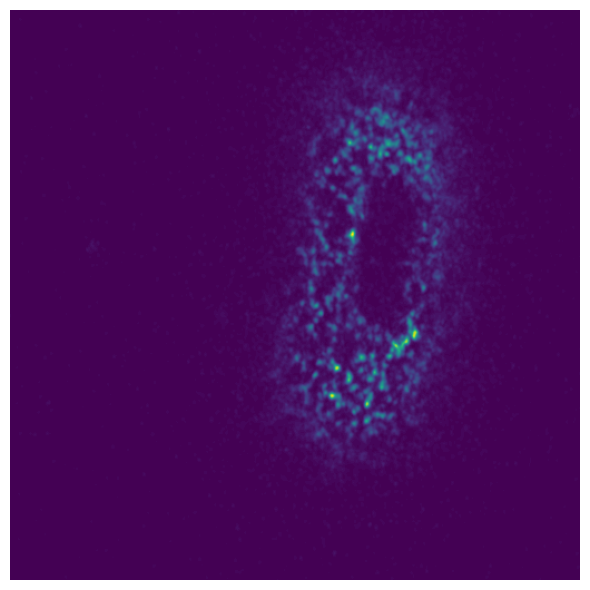

In [595]:
def visualize(data: np.ndarray, title: str = None, path: str = None):
    fig, ax = plt.subplots(1, 1, figsize=(6,6))

    ax.imshow(data, cmap='viridis')
    if title:
        ax.set_title(title)
    ax.axis('off')

    plt.tight_layout()
    plt.show()

    # Save the image if a path is provided
    if path:
        fig.savefig(path, format='png', dpi=300, pad_inches=0)

visualize(frame_a, title=None, path='piv/opiv_template.png')
visualize(frame_b, title=None, path='piv/opiv_search.png')

Before visualizing, we must save the velocity field in ASCII format.

In [596]:
tools.save(x, y, vel_x, vel_y, invalid_mask, 'piv/opiv_template_velocity.txt')

Finally, we can plot the velocity field onto the overlayed image. We could use the built-in plotting utilities in OpenPIV, but they make ugly figures and are hard to control. Rather, we create our own implementation. First, we replace all NaN values in the velocity with 0. Note; we do **NOT** normalize, since the result from OpenPIV gives us the number of pixels moved (in a specific dimension) in a frametime.

In [597]:
vel_x = np.nan_to_num(vel_x, 0)
vel_y = np.nan_to_num(vel_y, 0)

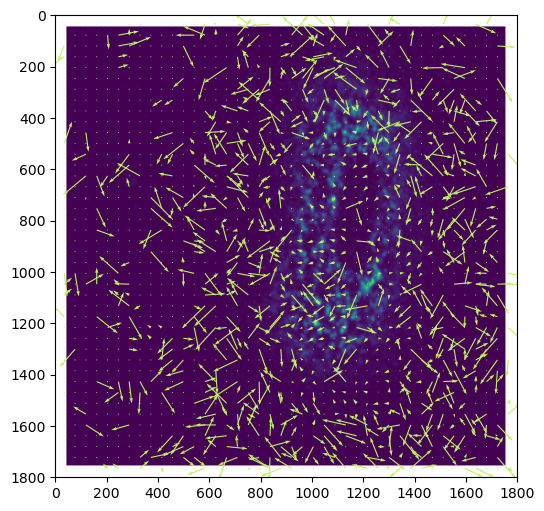

In [598]:
def visualize_velocity_field(frame_a, x, y, vel_x, vel_y, scale, overlay_path):
    # Load the background image
    img = mpimg.imread(overlay_path)
        
    img_width = img.shape[0]
    img_height = img.shape[1]

    spatial_scale_x = img_width / frame_a.shape[0]
    spatial_scale_y = img_height / frame_a.shape[1]

    x = x * spatial_scale_x
    y = y * spatial_scale_y

    # Create the plot
    plt.figure(figsize=(6, 6))
    plt.imshow(img, origin='upper')  # show image with origin at top-left

    # Ensure vel_x and vel_y are scaled
    vel_x_scaled = vel_x * scale
    vel_y_scaled = vel_y * scale

    # Plot velocity vectors
    plt.quiver(x, y, vel_x_scaled, vel_y_scaled, color='#bef264', angles='xy', scale_units='xy', scale=1)

    # Adjust plot limits to match the image
    plt.xlim(0, img.shape[1])
    plt.ylim(img.shape[0], 0)  # invert y-axis to match image coordinates
    plt.show()

visualize_velocity_field(frame_a, x, y, vel_x, vel_y, 1.0, 'piv/opiv_template.png')

## OpenPIV benchmark

We can now benchmark OpenPIV against the the specific points in the manually annotated data. We will first load this data 

In [615]:
df = Points.from_csv('out/points.csv')

We filter to our experiment and frame indices (i.e. time).

In [616]:
points_a = df.points_by_cell(experiment).points_by_time(frame_index_a)
points_b = df.points_by_cell(experiment).points_by_time(frame_index_b)

In [617]:
points_a

,Unnamed: 0,point_id,cell_id,cut,time,x_px,y_px,timestamp,x,y,x_parallel,x_perpendicular,cut_length,vx,vy,velocity,t_rel,v_parallel,v_perpendicular,velocity_cut
1,1,0,220530-E1_Out,False,4,371.0,192.0,2734.003849,18.681669,9.668142,0.784880,1.565061,4.704884,0.054438,0.000000,0.054438,2.774971,0.001115,0.054185,0.054197
9,9,1,220530-E1_Out,False,4,297.0,250.0,2734.003849,14.955407,12.588726,0.090722,-1.862552,4.704884,-0.163315,-0.018146,0.164320,2.774971,0.000495,-0.164303,0.164304
17,17,2,220530-E1_Out,False,4,377.0,224.0,2734.003849,18.983799,11.279499,0.450172,2.020998,4.704884,0.054438,0.000000,0.054438,2.774971,0.001115,0.054185,0.054197
24,24,3,220530-E1_Out,False,4,311.0,202.0,2734.003849,15.660375,10.171691,0.616495,-1.393680,4.704884,-0.217753,0.000000,0.217753,2.774971,-0.004458,-0.216741,0.216786
31,31,4,220530-E1_Out,False,4,311.0,217.0,2734.003849,15.660375,10.927014,0.456701,-1.320924,4.704884,-0.254045,-0.018146,0.254693,2.774971,-0.001362,-0.254612,0.254616
39,39,5,220530-E1_Out,False,4,310.0,182.0,2734.003849,15.610020,9.164593,0.828522,-1.540809,4.704884,-0.090730,-0.108877,0.141726,2.774971,0.021176,-0.100796,0.102996
47,47,6,220530-E1_Out,False,4,309.0,182.0,2734.003849,15.559665,9.164593,0.827491,-1.590930,4.704884,-0.127023,-0.036292,0.132106,2.774971,0.005077,-0.129928,0.130027
56,56,7,220530-E1_Out,True,4,333.0,262.0,2734.003849,16.768183,13.192985,0.000000,0.000000,4.704884,NaN,NaN,NaN,2.774971,NaN,NaN,NaN


We keep only the points that have "survived", and thus filter on points whose `point_id` is present

In [618]:
points_a = points_a[points_a['point_id'].isin(points_b['point_id'])]
points_b = points_b[points_b['point_id'].isin(points_a['point_id'])]

For all the points in `points_a`, we now compute their "expected position" based on the annotated velocity. We will call this the **ground truth** for now.

In [619]:
frame_diff = frame_index_b - frame_index_a

gt_updated_x = (points_a['x_px'] + frame_diff * points_a['vx']).to_numpy()
gt_updated_y = (points_a['y_px'] + frame_diff * points_a['vy']).to_numpy()

We can now predict the positions given the data from OpenPIV. One caveat is that we do not have a per-point velocity, rather a velocity grid. This means we will have to bilinearly interpolate between the four corner velocities.

In [620]:
points_ax = points_a['x_px'].to_numpy()
points_ay = points_a['y_px'].to_numpy()

In [621]:
# Use scipy for bilinear interpolation :)
from scipy.interpolate import RegularGridInterpolator

x_grid = x[0, :]
y_grid = y[:, 0]

vel_x_interp = RegularGridInterpolator((y_grid, x_grid), vel_x, bounds_error=False, fill_value=None)
vel_y_interp = RegularGridInterpolator((y_grid, x_grid), vel_y, bounds_error=False, fill_value=None)

ivel_x = [vel_x_interp((px, py)) for px, py in zip(points_ax, points_ay)]
ivel_y = [vel_y_interp((px, py)) for px, py in zip(points_ax, points_ay)]


Given the velocities in both x and y directions, we can predict the new positions.

In [622]:
predict_updated_x = (points_a['x_px'] + frame_diff * ivel_x).to_numpy()
predict_updated_y = (points_a['y_px'] + frame_diff * ivel_y).to_numpy()


In [623]:
# All to numpy

In [624]:
def rmse(gt, prediction):
    return np.sqrt(np.mean((prediction - gt) ** 2))

rmse_x = rmse(gt_updated_x, predict_updated_x)
rmse_y = rmse(gt_updated_y, predict_updated_y)

print(f'{rmse_x=}')
print(f'{rmse_y=}')


rmse_x=np.float64(27.563816811365488)
rmse_y=np.float64(32.98656160233716)


[-0.38276929  1.14830787 -0.38276929  1.53107716  1.78625669  0.63794882
  0.89312834]


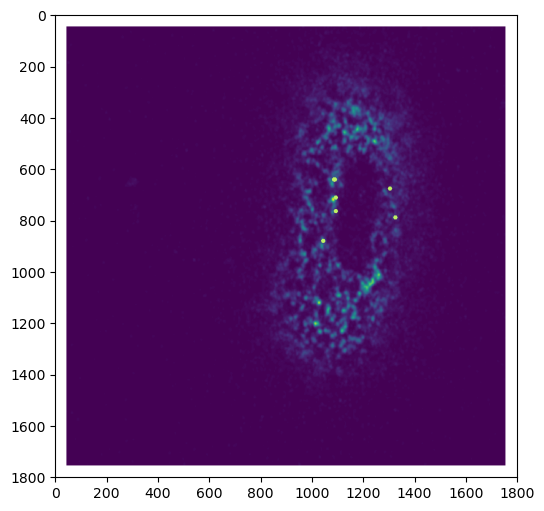

In [ ]:
def visualize_error(frame_a, ox, oy, dx_gt, dy_gt, dx_pred, dy_pred, scale, overlay_path):
    # Load the background image
    img = mpimg.imread(overlay_path)
        
    img_width = img.shape[0]
    img_height = img.shape[1]

    spatial_scale_x = img_width / frame_a.shape[0]
    spatial_scale_y = img_height / frame_a.shape[1]

    ox = ox * spatial_scale_x
    oy = oy * spatial_scale_y

    dx_gt = dx_gt * spatial_scale_x
    dy_gt = dy_gt * spatial_scale_y

    dx_pred = dx_pred * spatial_scale_x
    dy_pred = dy_pred * spatial_scale_y

    diff_x_gt = ox - dx_gt
    diff_y_gt = oy - dy_gt

    diff_x_pred = ox - dx_pred
    diff_y_pred = oy - dy_pred

    # Create the plot
    plt.figure(figsize=(6, 6))
    plt.imshow(img, origin='upper')  # show image with origin at top-left

    # Ensure scaling
    diff_x_scaled_gt        = diff_x_gt * scale
    diff_y_scaled_gt        = diff_y_gt * scale
    diff_x_scaled_pred      = diff_x_pred * scale
    diff_y_scaled_pred      = diff_y_pred * scale

    # Plot velocity vectors
    plt.quiver(ox, oy, diff_x_scaled_gt, diff_y_scaled_gt, color='#bef264', angles='xy', scale_units='xy', scale=1, width=0.01)
    #plt.quiver(ox, oy, diff_x_scaled_pred, diff_y_scaled_pred, color='#fde047', angles='xy', scale_units='xy', scale=1, width=0.004)

    # Adjust plot limits to match the image
    plt.xlim(0, img.shape[1])
    plt.ylim(img.shape[0], 0)  # invert y-axis to match image coordinates
    plt.show()

visualize_error(frame_a, points_ax, points_ay, gt_updated_x, gt_updated_y, predict_updated_x, predict_updated_y, 10, 'piv/opiv_template.png')